In [1]:
import pandas as pd

from pandas_datareader import data as pdr
import yfinance as yf
import streamlit as st
import numpy as np

from statsmodels.tsa.stattools import acf
from scipy.stats import wilcoxon, hmean

from tqdm.notebook import tqdm
from multiprocess import Pool
import multiprocessing

from matplotlib import pyplot as plt
import seaborn as sb

from optimal_weights import random_portfolio, min_var_portfolio, max_snr_portfolio
from evaluate_weights import evaluate_weights

import warnings
warnings.filterwarnings('ignore')

# Parameters

In [2]:
symbols=['AAPL', 'NKE', 'GOOGL', 'AMZN']
start = '2005-01-01' # expected datetime format is '%Y-%m-%d'
end = '2022-12-31'   # expected datetime format is '%Y-%m-%d

window_size = 100
num_portfolios = 10000

# Download historical prices (adjusted close)

In [3]:
yf.pdr_override()
price_df = pd.DataFrame()

for symbol in symbols:
    user_input = st.text_input('Enter Stock Ticker', symbol)
    tmp_df = pdr.get_data_yahoo(user_input, start=start, end=end)
    price_df = pd.concat([price_df, tmp_df['Adj Close']], axis='columns')

price_df.columns = symbols
price_df.head()

2023-01-09 15:12:42.094 
  command:

    streamlit run c:\anaconda3\envs\max_snr_portfolio_env\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AAPL,NKE,GOOGL,AMZN
2005-01-03 00:00:00,0.963384,9.136415,5.072823,2.2260
2005-01-04 00:00:00,0.973279,9.006457,4.867367,2.1070
2005-01-05 00:00:00,0.981803,8.898663,4.842593,2.0885
2005-01-06 00:00:00,0.982564,8.887577,4.718468,2.0525
2005-01-07 00:00:00,1.054106,8.835192,4.851101,2.1160


In [4]:
price_df.pct_change().describe()

,AAPL,NKE,GOOGL,AMZN
count,4530.000000,4530.000000,4530.000000,4530.000000
mean,0.001301,0.000725,0.000809,0.001095
std,0.020858,0.018051,0.018956,0.024336
min,-0.179195,-0.128081,-0.116341,-0.218220
25%,-0.008611,-0.007688,-0.007847,-0.009981
50%,0.001001,0.000577,0.000690,0.000560
75%,0.011992,0.009021,0.009770,0.012229
max,0.139049,0.155315,0.199915,0.269497


In [5]:
price_df.to_csv("../data/price_df.csv")

# Take independent subsamples (windows) from the data and generate portfolios

In [6]:
def get_largest_significant_lags(df, alfa=0.05):
    largest_significant_lag = 0
    
    for i in range(df.shape[1]):
        significant_lags = np.where(acf(df.iloc[:, i], missing="conservative", qstat=True)[-1] < alfa)[0]

        if significant_lags.shape[0] == 0:
            largest_significant_lag = max(largest_significant_lag, 0)
        else:
            # zero lag is ignored in the LB-test, so the index must be shifted by 1
            largest_significant_lag = max(largest_significant_lag, significant_lags[-1] + 1)
    
    return largest_significant_lag

In [7]:
price_df = pd.read_csv("../data/price_df.csv", index_col=0)
max_pool = multiprocessing.cpu_count()

window_start = 0
window_end = window_size
largest_significant_lag = 0
num_assets = len(price_df.columns)

results = []

with tqdm(total=price_df.shape[0]) as pbar:

    while window_start + window_size < price_df.shape[0]:
        window_df = price_df.iloc[window_start:window_end, :]
        
        # find mean and covariance of returns
        cov_matrix = window_df.pct_change().cov()
        exp_returns = window_df.pct_change().mean()
        
        cumul_returns_df = window_df / window_df.iloc[0,:]
        
        for longonly in [True, False]:
        
            w_min_var = min_var_portfolio(cov_matrix, longonly=longonly)
            w_max_snr = max_snr_portfolio(cov_matrix, exp_returns, longonly=longonly)

            # find random portfolio Hurst exponent(s)
            with Pool(max_pool) as p:
                pool_outputs = list(
                    tqdm(
                        p.imap(
                            random_portfolio,
                            [(seed, num_assets, cumul_returns_df, longonly) for seed in range(num_portfolios)]
                        ),
                        total=num_portfolios
                    )
                )

            results.append(
                evaluate_weights(w_min_var, cumul_returns_df) +
                evaluate_weights(w_max_snr, cumul_returns_df) +
                [ sum(x)/float(len(pool_outputs)) for x in zip(*pool_outputs) ] +
                [longonly]
            )
        
        ### move window 
        largest_significant_lag = get_largest_significant_lags(window_df.pct_change(), alfa=0.05)

        pbar.update(window_size + largest_significant_lag)
        
        window_start = window_end + largest_significant_lag
        window_end = window_start + window_size
    
    pbar.update(price_df.shape[0] - window_end)

  0%|          | 0/4531 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
results_df = pd.DataFrame(results, columns=["H1_minvar", "H2_minvar", "H3_minvar", "H4_minvar", "H1_maxsnr", "H2_maxsnr", "H3_maxsnr", "H4_maxsnr", "H1_random", "H2_random", "H3_random", "H4_random", "longonly"])
results_df.to_csv("../data/results_df.csv")
results_df

,H1_minvar,H2_minvar,H3_minvar,H4_minvar,H1_maxsnr,H2_maxsnr,H3_maxsnr,H4_maxsnr,H1_random,H2_random,H3_random,H4_random,longonly
0,0.581521,0.430251,0.296523,0.621193,0.597672,0.339020,0.284951,0.343100,0.553648,0.352840,0.304260,0.357984,True
1,0.605457,0.441757,0.327740,0.510996,0.709003,0.610876,0.477471,0.589520,0.639105,0.475358,0.449309,0.519961,False
2,0.607896,0.475857,0.477936,0.320252,0.599098,0.622711,0.401470,0.492996,0.554260,0.481295,0.366176,0.472819,True
3,0.608112,0.475861,0.478217,0.313273,0.526092,0.612521,0.355752,0.524918,0.582843,0.522527,0.412258,0.552765,False
4,0.673325,0.370659,0.400497,0.169290,0.679072,0.882161,0.384536,0.453656,0.731289,0.419640,0.478121,0.457828,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.669835,0.371486,0.502335,0.606722,0.595183,0.323107,0.541702,0.610133,0.627688,0.396030,0.414625,0.509667,False
80,0.562332,0.387205,0.387596,0.624924,0.520897,0.369098,0.368765,0.629611,0.550360,0.440778,0.444466,0.622622,True
81,0.560173,0.308959,0.319039,0.551661,0.605071,0.247543,0.247412,0.324904,0.590516,0.426245,0.441944,0.525712,False
82,0.737583,0.451371,0.467011,0.465070,0.774367,0.463235,0.488249,0.440806,0.695549,0.436663,0.442189,0.514664,True


# Analyze portfolios

In [9]:
results_df = pd.read_csv("../data/results_df.csv", index_col=0)
results_df

,H1_minvar,H2_minvar,H3_minvar,H4_minvar,H1_maxsnr,H2_maxsnr,H3_maxsnr,H4_maxsnr,H1_random,H2_random,H3_random,H4_random,longonly
0,0.581521,0.430251,0.296523,0.621193,0.597672,0.339020,0.284951,0.343100,0.553648,0.352840,0.304260,0.357984,True
1,0.605457,0.441757,0.327740,0.510996,0.709003,0.610876,0.477471,0.589520,0.639105,0.475358,0.449309,0.519961,False
2,0.607896,0.475857,0.477936,0.320252,0.599098,0.622711,0.401470,0.492996,0.554260,0.481295,0.366176,0.472819,True
3,0.608112,0.475861,0.478217,0.313273,0.526092,0.612521,0.355752,0.524918,0.582843,0.522527,0.412258,0.552765,False
4,0.673325,0.370659,0.400497,0.169290,0.679072,0.882161,0.384536,0.453656,0.731289,0.419640,0.478121,0.457828,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.669835,0.371486,0.502335,0.606722,0.595183,0.323107,0.541702,0.610133,0.627688,0.396030,0.414625,0.509667,False
80,0.562332,0.387205,0.387596,0.624924,0.520897,0.369098,0.368765,0.629611,0.550360,0.440778,0.444466,0.622622,True
81,0.560173,0.308959,0.319039,0.551661,0.605071,0.247543,0.247412,0.324904,0.590516,0.426245,0.441944,0.525712,False
82,0.737583,0.451371,0.467011,0.465070,0.774367,0.463235,0.488249,0.440806,0.695549,0.436663,0.442189,0.514664,True


In [10]:
portfolios = ["maxsnr", "minvar", "random"]

# H1: rescaled range
# H2: robust variance of lagged difference
# H3: variance of lagged difference
# H4: fractal dimensiong
hurst_estimators = ["H1", "H2", "H3", "H4"]

## Check Hurst estimator distributions

Long-only case

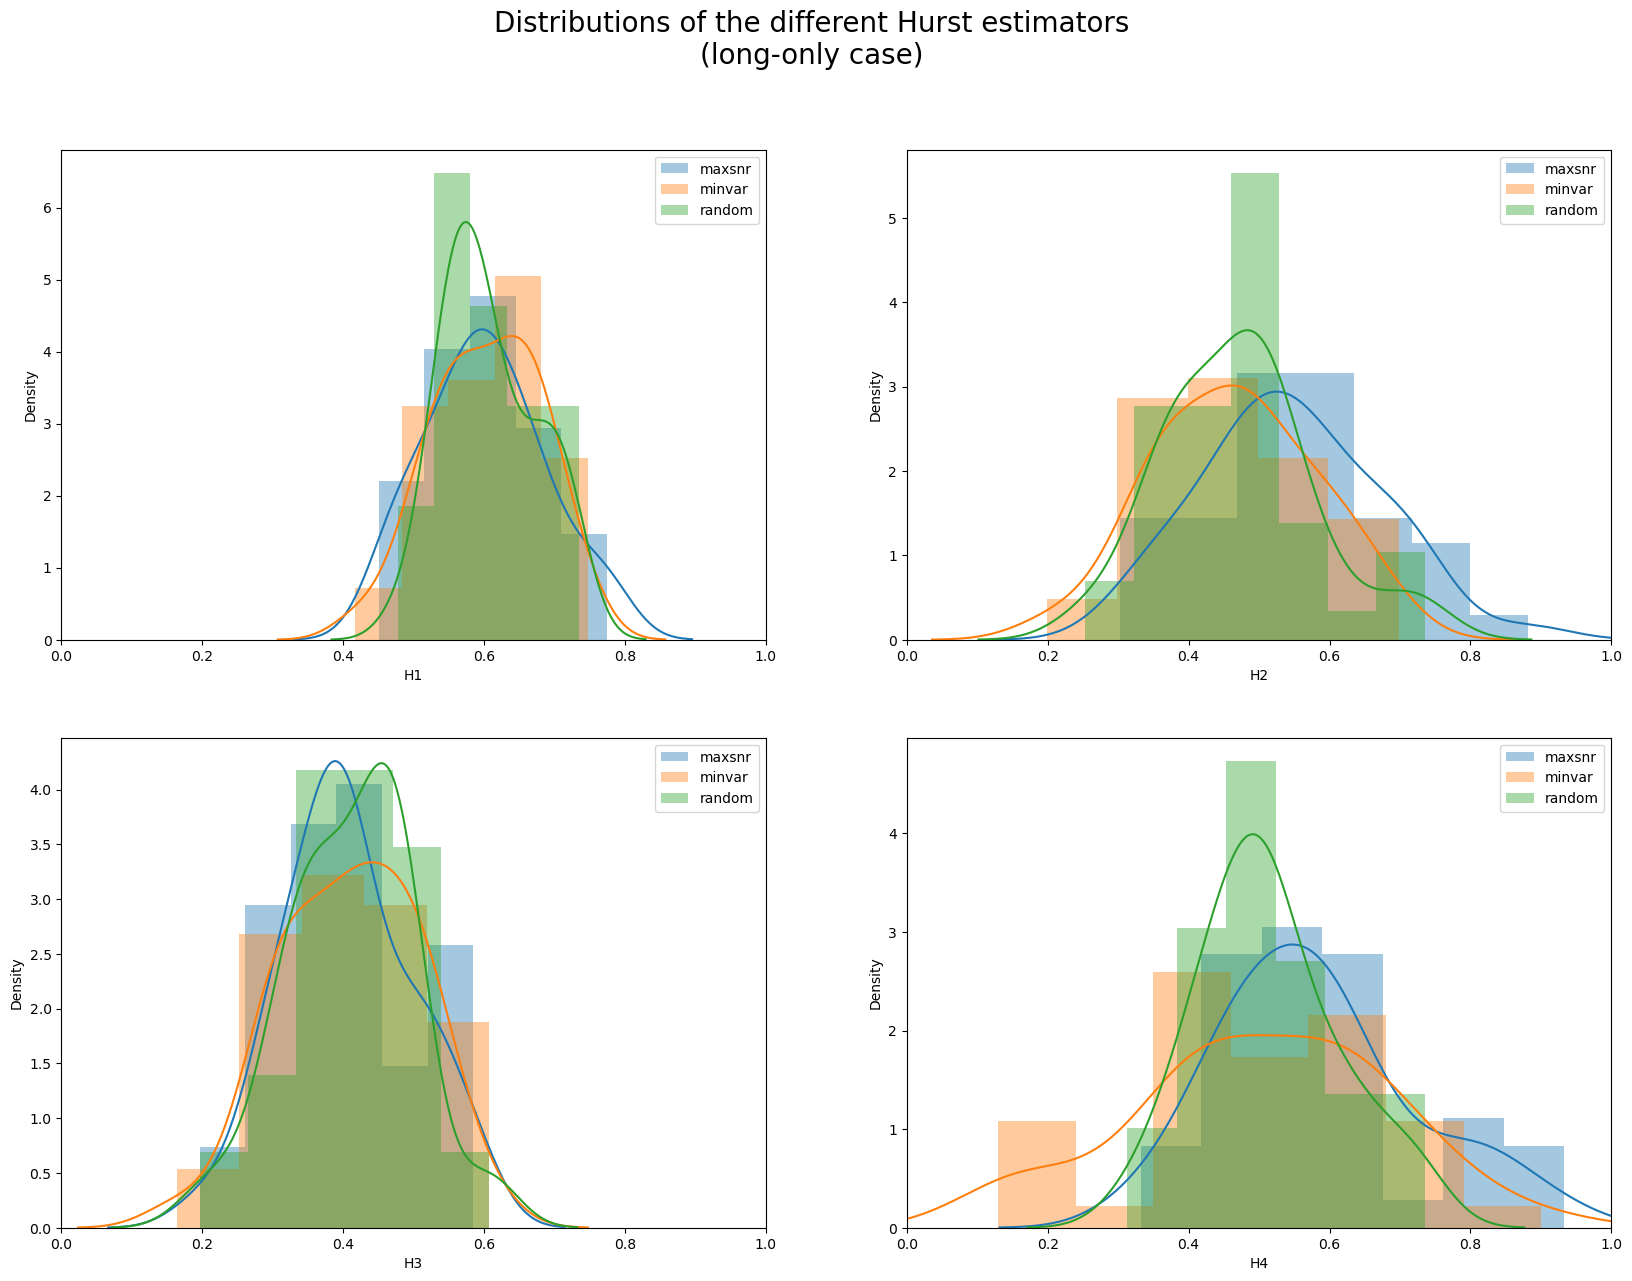

In [17]:
longonly = results_df.longonly == True

fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle("Distributions of the different Hurst estimators\n(long-only case)", fontsize=20)

for j in range(len(hurst_estimators)):
    for i in range(len(portfolios)):
        ax = axes[j // 2][j % 2]
        sb.distplot(results_df[longonly][hurst_estimators[j]+"_"+portfolios[i]], kde=True, label=portfolios[i], ax=ax)
        ax.set_xlabel(hurst_estimators[j])
        ax.legend(loc="upper right")
        ax.set_xlim(0.0, 1.0)

Long-short case

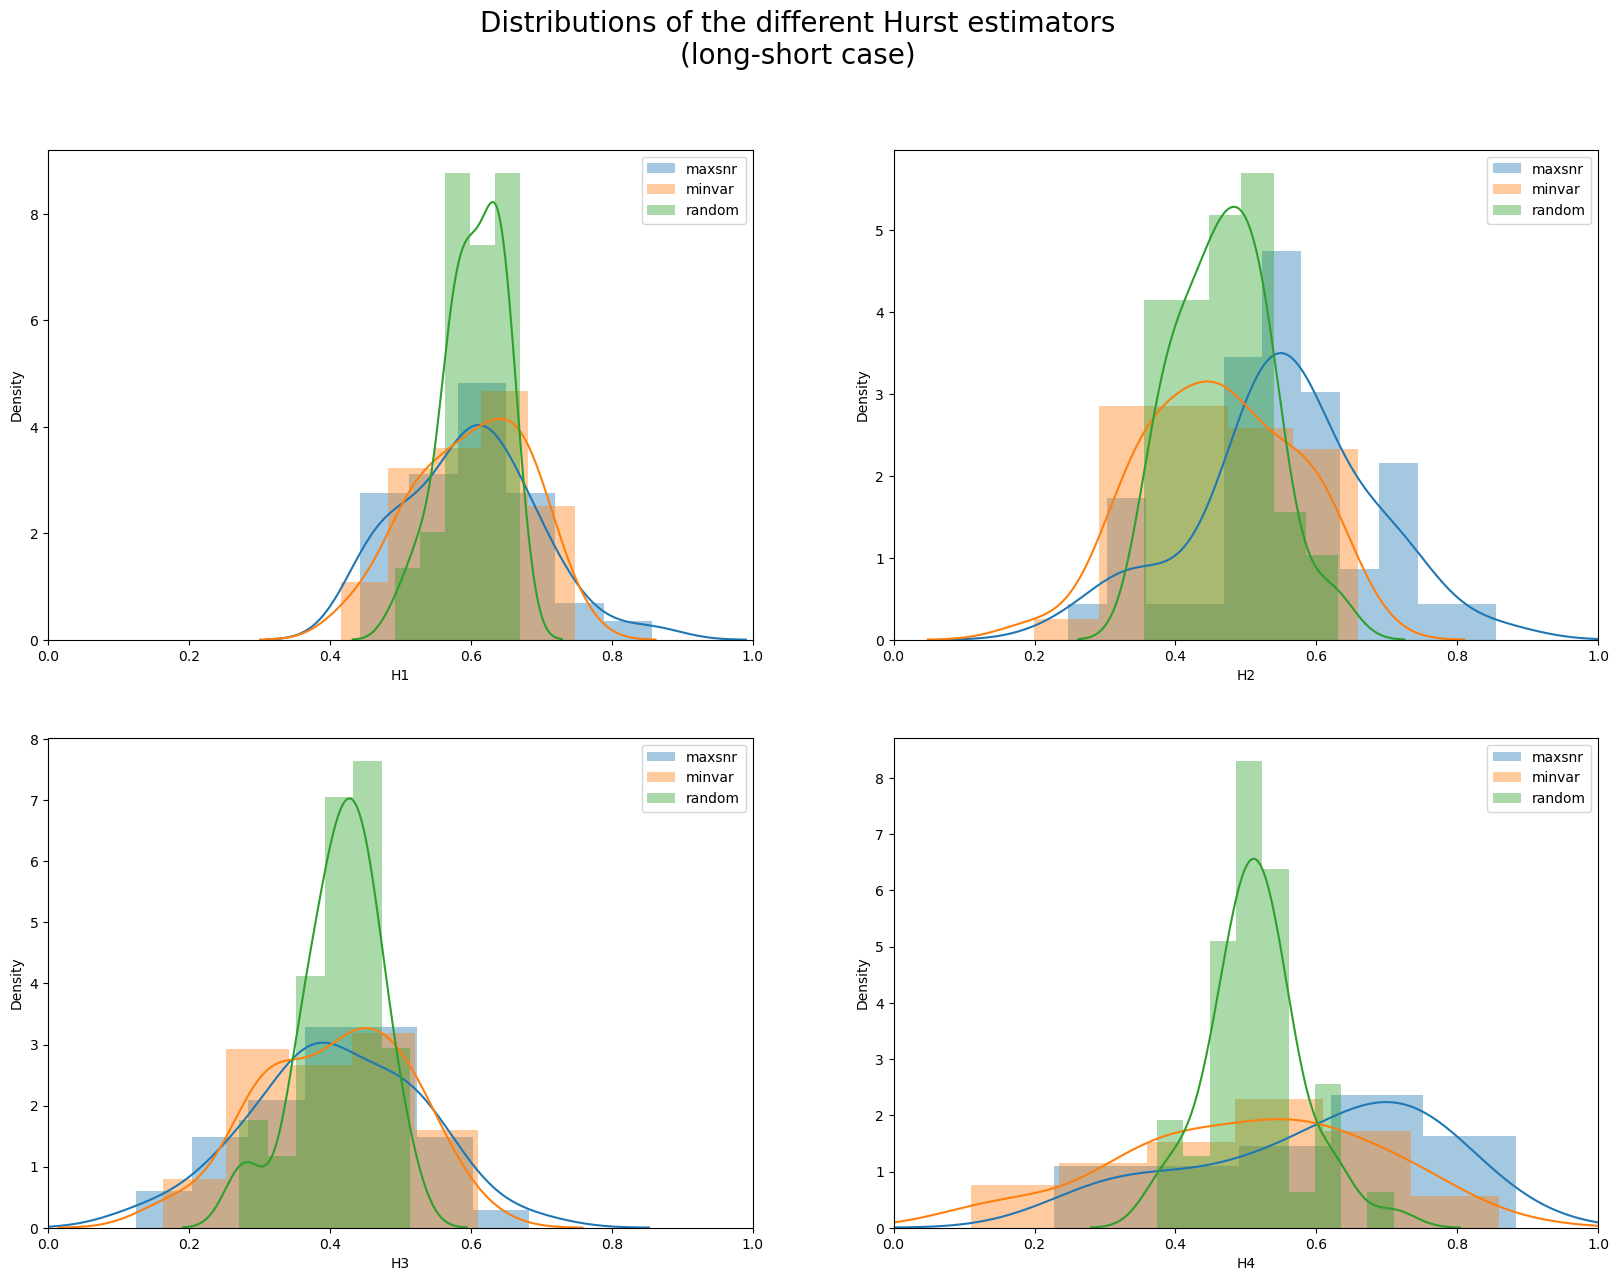

In [16]:
mask = results_df.longonly == False

fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle("Distributions of the different Hurst estimators\n(long-short case)", fontsize=20)

for j in range(len(hurst_estimators)):
    for i in range(len(portfolios)):
        ax = axes[j // 2][j % 2]
        sb.distplot(results_df[~longonly][hurst_estimators[j]+"_"+portfolios[i]], kde=True, label=portfolios[i], ax=ax)
        ax.set_xlabel(hurst_estimators[j])
        ax.legend(loc="upper right")
        ax.set_xlim(0.0, 1.0)

## Hypothesis test: equivalence of means

In [13]:
# H0: sample means are equal
# H1: the first mean is larger than the second

Long-only case

In [14]:
index = []
data = []

# Test equivalence
cntr = 0
for i in range(len(portfolios)):
    for j in range(i+1, len(portfolios)):
        index.append((cntr, portfolios[i], "mean"))
        data.append([results_df[longonly][hurst_estimator+"_"+portfolios[i]].mean() for hurst_estimator in hurst_estimators] + [""])
        
        index.append((cntr, portfolios[j], "mean"))
        data.append([results_df[longonly][hurst_estimator+"_"+portfolios[j]].mean() for hurst_estimator in hurst_estimators] + [""])
        
        index.append((cntr, "Wilcoxon", "T"))
        index.append((cntr, "Wilcoxon", "p"))
        
        data.append([wilcoxon(results_df[longonly][hurst_estimator+"_"+portfolios[i]], results_df[longonly][hurst_estimator+"_"+portfolios[j]], alternative="greater")[0] for hurst_estimator in hurst_estimators] + [""])
        data.append([wilcoxon(results_df[longonly][hurst_estimator+"_"+portfolios[i]], results_df[longonly][hurst_estimator+"_"+portfolios[j]], alternative="greater")[1] for hurst_estimator in hurst_estimators])
        data[-1].append(hmean(data[-1]))
        
        cntr += 1

pd.DataFrame(data, index=pd.MultiIndex.from_tuples(index), columns=hurst_estimators+["hmp"])

H1          H2          H3          H4       hmp
0 maxsnr   mean    0.601487    0.545089    0.406082    0.581861          
  minvar   mean    0.604106    0.464073    0.409810    0.502570          
  Wilcoxon T     439.000000  728.000000  394.000000  635.000000          
           p       0.563888    0.000171    0.763869    0.010510  0.000672
1 maxsnr   mean    0.601487    0.545089    0.406082    0.581861          
  random   mean    0.607961    0.469402    0.410983    0.512540          
  Wilcoxon T     403.000000  735.000000  401.000000  685.000000          
           p       0.728057    0.000115    0.736238    0.001454  0.000427
2 minvar   mean    0.604106    0.464073    0.409810    0.502570          
  random   mean    0.607961    0.469402    0.410983    0.512540          
  Wilcoxon T     453.000000  399.000000  438.000000  429.000000          
           p       0.495065    0.744294    0.568756    0.612027  0.592099

Long-short case

In [15]:
index = []
data = []

# Test equivalence
cntr = 0
for i in range(len(portfolios)):
    for j in range(i+1, len(portfolios)):
        index.append((cntr, portfolios[i], "mean"))
        data.append([results_df[~longonly][hurst_estimator+"_"+portfolios[i]].mean() for hurst_estimator in hurst_estimators] + [""])
        
        index.append((cntr, portfolios[j], "mean"))
        data.append([results_df[~longonly][hurst_estimator+"_"+portfolios[j]].mean() for hurst_estimator in hurst_estimators] + [""])
        
        index.append((cntr, "Wilcoxon", "T"))
        index.append((cntr, "Wilcoxon", "p"))
        
        data.append([wilcoxon(results_df[~longonly][hurst_estimator+"_"+portfolios[i]], results_df[~longonly][hurst_estimator+"_"+portfolios[j]], alternative="greater")[0] for hurst_estimator in hurst_estimators] + [""])
        data.append([wilcoxon(results_df[~longonly][hurst_estimator+"_"+portfolios[i]], results_df[~longonly][hurst_estimator+"_"+portfolios[j]], alternative="greater")[1] for hurst_estimator in hurst_estimators])
        data[-1].append(hmean(data[-1]))
        
        cntr += 1

pd.DataFrame(data, index=pd.MultiIndex.from_tuples(index), columns=hurst_estimators+["hmp"])

H1          H2          H3          H4       hmp
0 maxsnr   mean    0.597254    0.551299    0.408030    0.597980          
  minvar   mean    0.600239    0.460633    0.404813    0.501470          
  Wilcoxon T     419.000000  759.000000  454.000000  633.000000          
           p       0.658536    0.000027    0.490131    0.011263  0.000107
1 maxsnr   mean    0.597254    0.551299    0.408030    0.597980          
  random   mean    0.604001    0.468400    0.413696    0.513517          
  Wilcoxon T     405.000000  773.000000  446.000000  688.000000          
           p       0.719755    0.000010    0.529584    0.001270  0.000041
2 minvar   mean    0.600239    0.460633    0.404813    0.501470          
  random   mean    0.604001    0.468400    0.413696    0.513517          
  Wilcoxon T     455.000000  382.000000  414.000000  435.000000          
           p       0.485198    0.807371    0.680983    0.583296   0.61705